In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import yfinance as yf
import seaborn as sns

# Download stock data
ticker = "AAPL"
start_date = "2018-01-01"
end_date = "2024-06-23"
data = yf.download(ticker, start=start_date, end=end_date)

# Prepare the data
ts = data['Close']

# Check for stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1]

p_val = test_stationarity(ts)

if p_val > 0.05:
    # If non-stationary, difference the series
    ts_diff = ts.diff().dropna()
    p_val = test_stationarity(ts_diff)
    d = 1
    if p_val > 0.05:
        ts_diff = ts.diff().diff().dropna()
        p_val = test_stationarity(ts_diff)
        d = 2

print(f"\nd = {d}")


[*********************100%%**********************]  1 of 1 completed

ADF Statistic: -0.5415163597258146
p-value: 0.8836571010380605
ADF Statistic: -41.28457622791648
p-value: 0.0

d = 1


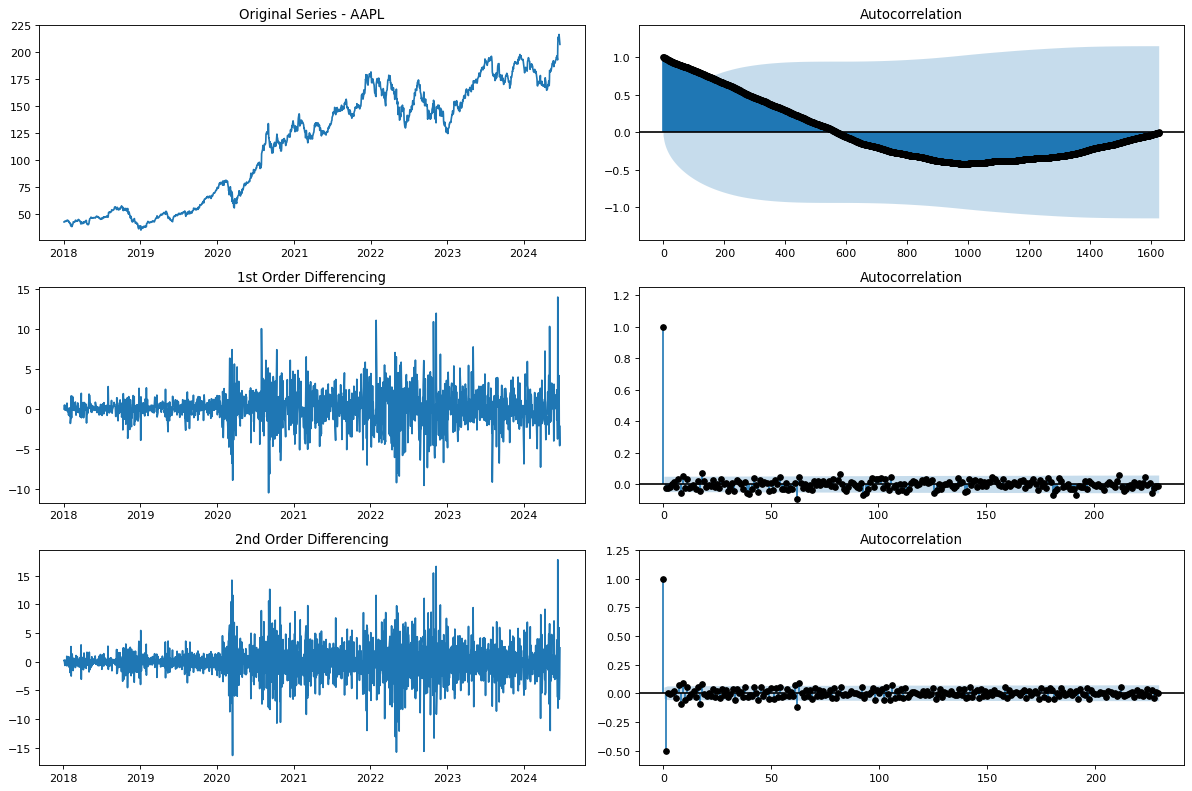

In [212]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':80})

# Import data
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df = data.copy()

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.index, df.Close); axes[0, 0].set_title('Original Series - '+ticker)
plot_acf(df.Close, ax=axes[0, 1], lags=len(df)-1, color='k', auto_ylims=True)

# 1st Differencing
axes[1, 0].plot(df.index, df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1], lags=len(df)/7-2, color='k', auto_ylims=True)

# 2nd Differencing
axes[2, 0].plot(df.index, df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1], lags=len(df)/7-3, color='k', auto_ylims=True)

# plt.xlim([])
plt.tight_layout()
plt.savefig("images/find_d.png", dpi=300)
plt.show()


## Find p

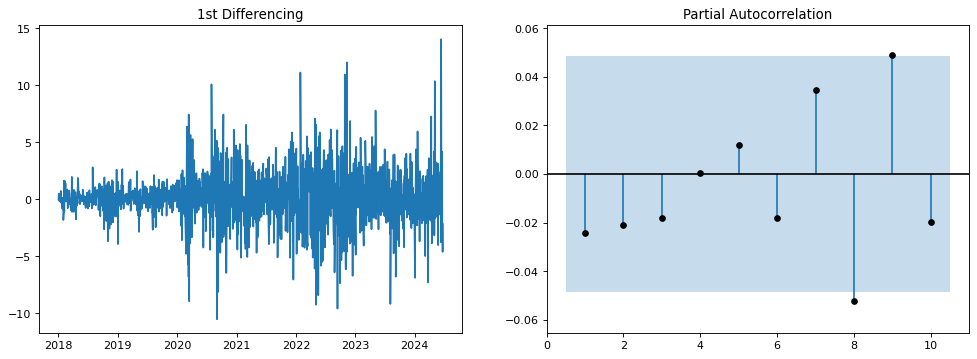

In [232]:
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':80})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.index, df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Close.diff().dropna(), ax=axes[1], lags=10, color='k', auto_ylims=True, zero=False)

plt.savefig("images/find_p.png", dpi=300)
plt.show()

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1628
Model:                 ARIMA(8, 1, 3)   Log Likelihood               -3630.156
Date:                Sat, 29 Jun 2024   AIC                           7284.312
Time:                        14:08:41   BIC                           7349.046
Sample:                             0   HQIC                          7308.330
                               - 1628                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0520      0.721     -1.460      0.144      -2.465       0.361
ar.L2          0.4481      1.321      0.339      0.734      -2.140       3.036
ar.L3          0.7035      0.713      0.987      0.3

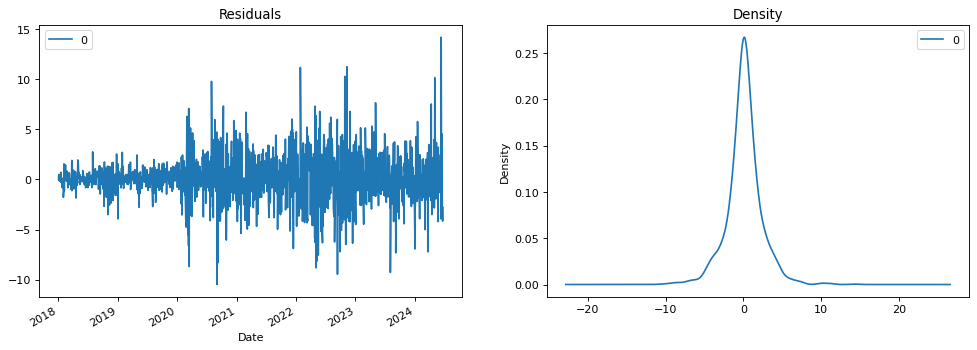

In [233]:
# Fit ARIMA model
model = ARIMA(df.Close, order=(8,1,3)) # p,d,q
results = model.fit()
print(results.summary())

# Fit ARIMA model
# model = ARIMA(df.Close, order=(1,1,2)) # p,d,q
# results = model.fit()
# print(results.summary())

# Plot residual errors
residuals = pd.DataFrame(results.resid[1:])
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Forecast
# forecast,  = results.forecast(steps=30)
# # help(forecast)
# print(forecast)

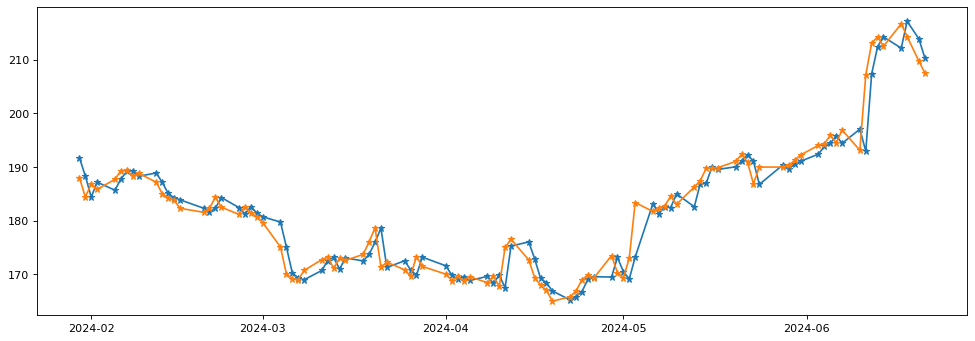

(DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
                '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
                '2018-01-12', '2018-01-16',
                ...
                '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12',
                '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18',
                '2024-06-20', '2024-06-21'],
               dtype='datetime64[ns]', name='Date', length=1628, freq=None),
 DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
                '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
                '2018-01-12', '2018-01-16',
                ...
                '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12',
                '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18',
                '2024-06-20', '2024-06-21'],
               dtype='datetime64[ns]', name='Date', length=1628, freq=None))

In [234]:
# Actual vs Fitted
# results.plot_predict(dynamic=False)
plt.plot(results.predict()[-100:], '-*' ='forecast')
plt.plot(df.Close[-100:], '-*', label='actual')
plt.show()
df.index, results.predict().index

## Train / Test Split

In [226]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.Close[:int(len(df)*0.8)]
test = df.Close[int(len(df)*0.8):]

In [227]:
# x = fitted.get_prediction(16)
# # fitted.conf_int()
# predict_dy = fitted.get_prediction(start=train.index[0], end=train.index[-1], nforecast=len(test))
# predict_dy_ci = predict_dy.conf_int()
# predict_dy_ci
# conf.iloc[:, 1]
# fc.predicted_mean

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

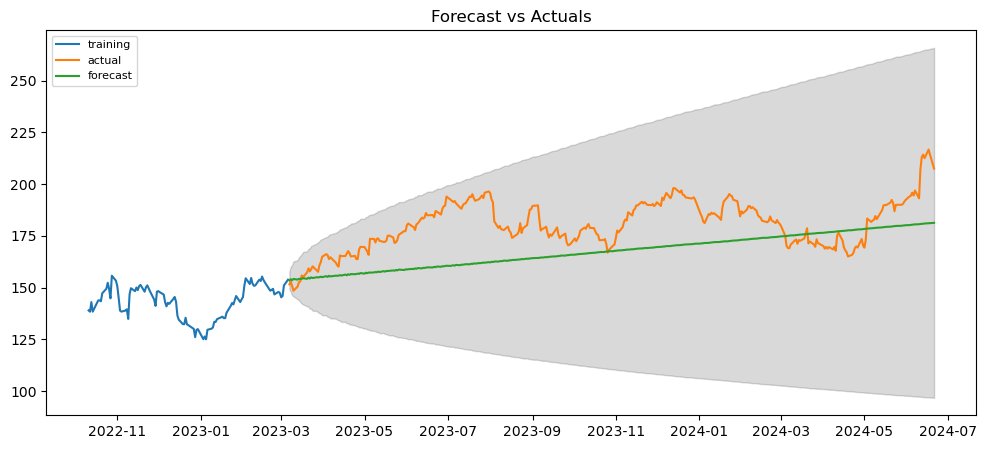

In [228]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(3, 2, 3))  
fitted = model.fit()  

# Forecast
fc = fitted.get_forecast(steps=len(test), alpha=0.05)  # 95% conf
conf = fc.conf_int()

# Make as pandas series
fc_series = pd.Series(fitted.forecast(steps=len(test)).values, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-100:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [231]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))    # MAPE
    me = np.mean(forecast - actual)                             # ME
    mae = np.mean(np.abs(forecast - actual))                    # MAE
    mpe = np.mean((forecast - actual)/actual)                   # MPE
    rmse = np.mean((forecast - actual)**2)**.5                  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)                             # minmax
    acf1 = acf(forecast-test)[1]                                # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc_series.values, test.values)
# fc_series.values

{'mape': 0.0775511146193039,
 'me': -12.694348658599367,
 'mae': 14.344273811328671,
 'mpe': -0.06772738640179471,
 'rmse': 16.75431073067283,
 'acf1': 0.9704000614337356,
 'corr': 0.44840864171928424,
 'minmax': 0.0773475324762326}

NameError: name 'forecast' is not defined

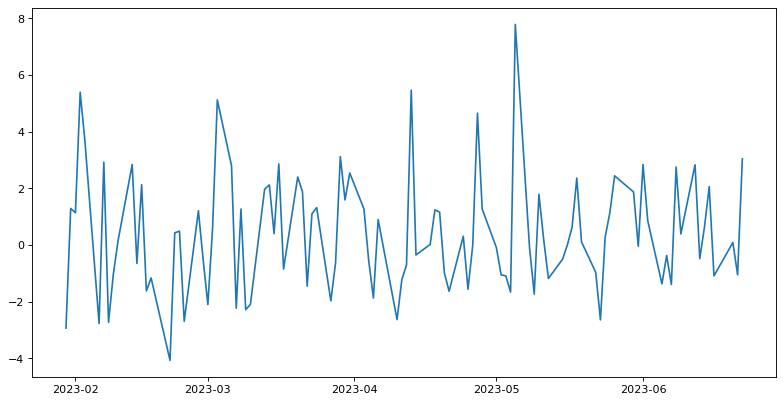

In [ ]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(ts.index[-100:], ts_diff.values[-100:], label='Observed')
plt.plot(ts.index[-30:], forecast.values, color='r', label='Forecast')
# plt.fill_between(forecast.index, 
#                  forecast.iloc[:, 0], 
#                  forecast.iloc[:, 1], 
#                  color='pink', alpha=0.3)
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(ts.diff().dropna()[-30:], forecast)
print(f'Mean Squared Error: {mse}')

Suggested d value: 0


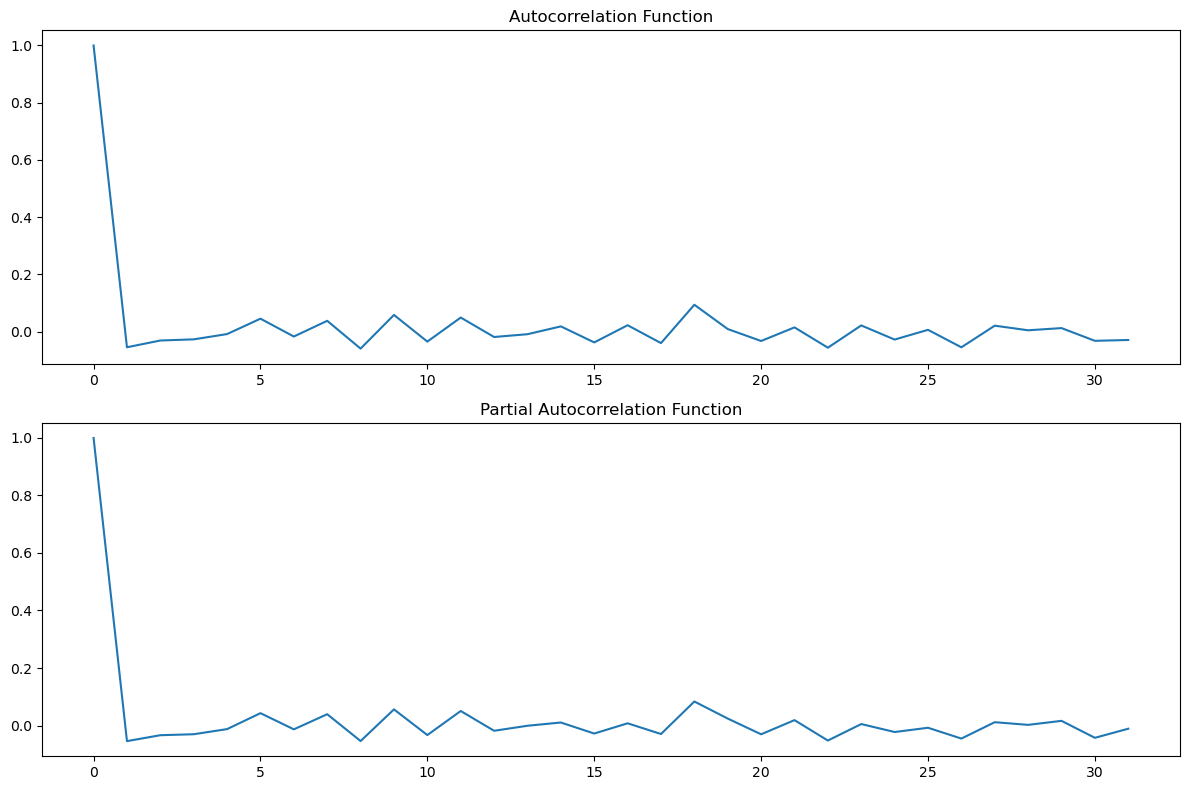

c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\stefa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

def find_d_value(timeseries):
    d = 0
    while True:
        result = adfuller(timeseries)
        if result[1] < 0.05:
            break
        timeseries = timeseries.diff().dropna()
        d += 1
    return d, timeseries

def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
    acf_values = acf(timeseries)
    pacf_values = pacf(timeseries)
    ax1.plot(acf_values)
    ax1.set_title('Autocorrelation Function')
    ax2.plot(pacf_values)
    ax2.set_title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()

def grid_search_arima(timeseries, p_range, d_range, q_range):
    best_aic = float('inf')
    best_order = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(timeseries, order=(p,d,q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                except:
                    continue
    return best_order

# Assuming 'ts' is your time series data
d, stationary_ts = find_d_value(ts_diff)
print(f"Suggested d value: {d}")

plot_acf_pacf(stationary_ts)

# Grid search for best p and q (assuming d is known)
best_order = grid_search_arima(ts, range(0,6), [d], range(0,6))
print(f"Best ARIMA order based on grid search: {best_order}")

# Alternatively, use auto_arima for automatic parameter selection
model = auto_arima(ts, start_p=0, start_q=0, max_p=5, max_q=5, m=1, d=None, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)
print(f"Best ARIMA order based on auto_arima: {model.order}")